# Name: Sai Sriharsha Griddaluru
## Email: sgridda@clemson.edu
## CUID: C15358926


# HW 1: TASK 3: Flatness vs Generalization

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
transform = transforms.ToTensor()


In [3]:
train_data_set = datasets.MNIST(root='deep-learning/hw-1/dataset-5', train=True, download=True, transform=transform)
test_data_set = datasets.MNIST(root='deep-learning/hw-1/dataset-5', train=False, download=True, transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 8901963.23it/s] 


Extracting deep-learning/hw-1/dataset-5/MNIST/raw/train-images-idx3-ubyte.gz to deep-learning/hw-1/dataset-5/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 2035483.50it/s]

Extracting deep-learning/hw-1/dataset-5/MNIST/raw/train-labels-idx1-ubyte.gz to deep-learning/hw-1/dataset-5/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 15554331.70it/s]


Extracting deep-learning/hw-1/dataset-5/MNIST/raw/t10k-images-idx3-ubyte.gz to deep-learning/hw-1/dataset-5/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 8429437.51it/s]


Extracting deep-learning/hw-1/dataset-5/MNIST/raw/t10k-labels-idx1-ubyte.gz to deep-learning/hw-1/dataset-5/MNIST/raw



In [4]:
print(train_data_set)
print(test_data_set)

Dataset MNIST
    Number of datapoints: 60000
    Root location: deep-learning/hw-1/dataset-5
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: deep-learning/hw-1/dataset-5
    Split: Test
    StandardTransform
Transform: ToTensor()


In [5]:
batch_sizes = [5, 25, 125, 500, 1000]
train_loaders = [DataLoader(train_data_set, batch_size=b, shuffle=True) for b in batch_sizes]
test_loaders = [DataLoader(test_data_set, batch_size=b, shuffle=True) for b in batch_sizes]

In [6]:
class Model(nn.Module):
    def __init__(self, in_features=784, h1=20, h2=20, out_features=10):
        super().__init__()
        self.fc1 = nn.Linear(in_features, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.out = nn.Linear(h2, out_features)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

In [7]:
def calc_params(model):
    return sum(params.numel() for params in model.parameters() if params.requires_grad)

In [8]:
def calc_sensitivity(model):
    frob_norm_all = 0
    counter = 0
    for p in model.parameters():
        if p.grad is not None:
            frob_norm_all += torch.linalg.norm(p.grad).numpy()
            counter += 1
    return frob_norm_all / counter if counter > 0 else 0

In [9]:
def train_test_model(model, criterion, optimizer, train_loader, test_loader, epochs):
    train_losses, test_losses = [], []
    train_correct, test_correct = [], []
    
    for i in range(epochs):
        train_corr, test_corr = 0, 0

        # Training loop
        for b, (X_train, y_train) in enumerate(train_loader):
            y_pred = model(X_train.view(X_train.size(0), -1))  
            loss = criterion(y_pred, y_train)
            
            # Tally correct predictions
            predicted = torch.max(y_pred.data, 1)[1]
            train_corr += (predicted == y_train).sum()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_losses.append(loss.item())
        train_correct.append(train_corr.item())
        
        # Testing loop
        with torch.no_grad():
            for b, (X_test, y_test) in enumerate(test_loader):
                y_val = model(X_test.view(X_test.size(0), -1))
                predicted = torch.max(y_val.data, 1)[1]
                test_corr += (predicted == y_test).sum()
        
        test_losses.append(criterion(y_val, y_test).item())
        test_correct.append(test_corr.item())
    
    return train_losses, test_losses, train_correct, test_correct

In [12]:
models = [Model() for _ in batch_sizes]
criteria = [nn.CrossEntropyLoss() for _ in models]
optimizers = [torch.optim.Adam(model.parameters(), lr=0.001) for model in models]

In [14]:
train_loss_list, test_loss_list = [], []
train_accuracy_list, test_accuracy_list = [], []
sensitivity_list = []

In [15]:
epochs = 10
for i, (model, criterion, optimizer, train_loader, test_loader) in enumerate(zip(models, criteria, optimizers, train_loaders, test_loaders)):
    # Train and test the model
    train_losses, test_losses, train_corr, test_corr = train_test_model(model, criterion, optimizer, train_loader, test_loader, epochs)
    
    # Append the last epoch's results to the lists
    train_loss_list.append(train_losses[-1])
    test_loss_list.append(test_losses[-1])
    train_accuracy_list.append(train_corr[-1] / len(train_data_set))
    test_accuracy_list.append(test_corr[-1] / len(test_data_set))
    
    # Calculate sensitivity
    sensitivity_list.append(calc_sensitivity(model))

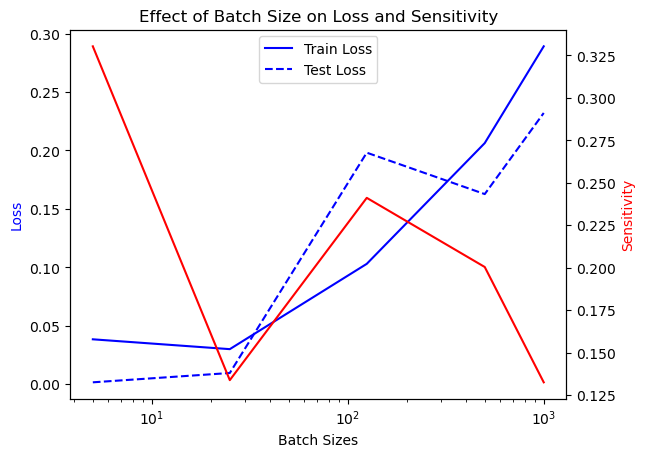

In [16]:
# Visualization
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(batch_sizes, train_loss_list, 'b', label='Train Loss')
ax1.plot(batch_sizes, test_loss_list, 'b--', label='Test Loss')
ax2.plot(batch_sizes, sensitivity_list, 'r', label='Sensitivity')
ax1.set_title('Effect of Batch Size on Loss and Sensitivity')
ax1.set_xlabel('Batch Sizes')
ax1.set_xscale('log')
ax1.set_ylabel('Loss', color='b')
ax2.set_ylabel('Sensitivity', color='r')
ax1.legend(loc='upper center')

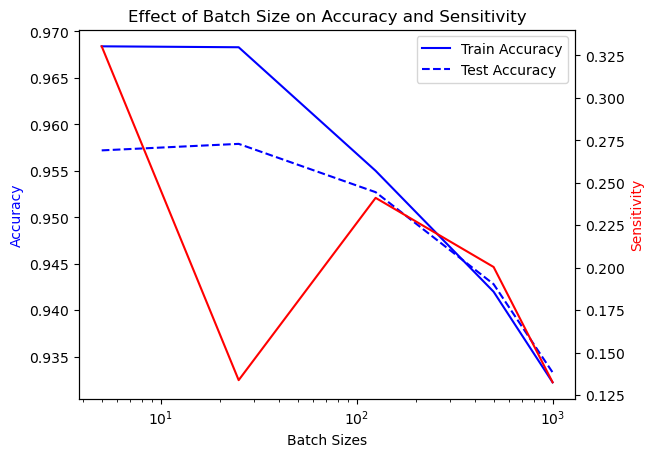

In [17]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(batch_sizes, train_accuracy_list, 'b', label='Train Accuracy')
ax1.plot(batch_sizes, test_accuracy_list, 'b--', label='Test Accuracy')
ax2.plot(batch_sizes, sensitivity_list, 'r', label='Sensitivity')
ax1.set_title('Effect of Batch Size on Accuracy and Sensitivity')
ax1.set_xlabel('Batch Sizes')
ax1.set_xscale('log')
ax1.set_ylabel('Accuracy', color='b')
ax2.set_ylabel('Sensitivity', color='r')
ax1.legend(loc='upper right')

plt.show()